# **Achieving 95% Accuracy on CIFAR10 with Elegy**
***

## **Install Elegy**

In [ ]:
!pip install git+https://github.com/alexander-g/elegy.git@a34b6696977f72e224722009ef8d18653cc143b2
!pip install dataget

In [2]:
import elegy
import optax
import jax, jax.numpy as jnp
import numpy as np
from pylab import *
import dataget

***
## **Download CIFAR10**

In [3]:
x_train, y_train, x_test, y_test = dataget.image.cifar10().get()
y_train = y_train.squeeze()
y_test  = y_test.squeeze()

x_mean  = x_train.mean(axis=2).mean(axis=1).mean(axis=0)
x_std   = x_train.std(axis=2).std(axis=1).std(axis=0)

x_test  = (x_test  - x_mean)/x_std
x_train = (x_train - x_mean)/x_std


In [4]:
def augment(x):
  x = x[:,::-1] if np.random.random()<0.5 else x        #random horizontal flip
  x = np.pad(x, pad_width=[(4,4),(4,4),(0,0)])          #pad for shifting
  i = np.random.randint(0,4*2+1, size=2)                #indices for shifting
  x = x[i[0]:,i[1]:][:32, :32]                          #horizontal/vertical shift
  return x

In [5]:
def batch_generator(images, labels, batch_size=64, training=False):
  while 1:
    indices = np.arange(len(images))
    if training:
      np.random.shuffle(indices)
    
    for batch_start in range(0, len(indices), batch_size):
      batch_indices = indices[batch_start:][:batch_size]
      x_batch = images[batch_indices]
      y_batch = labels[batch_indices]
      if training:
        x_batch = [augment(x) for x in x_batch]

      yield jnp.asarray(x_batch), jnp.asarray(y_batch)

In [6]:
BATCH_SIZE = 64

generator_train = batch_generator(x_train, y_train, training=True,  batch_size=BATCH_SIZE)
generator_test  = batch_generator(x_test,  y_test,  training=False, batch_size=BATCH_SIZE)

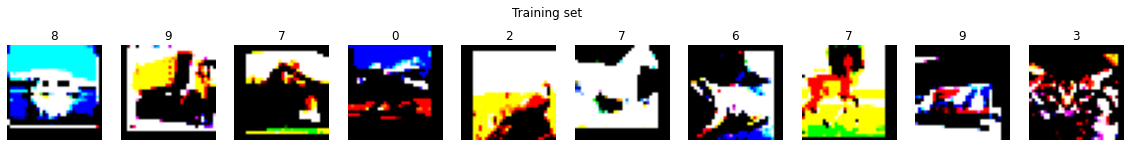

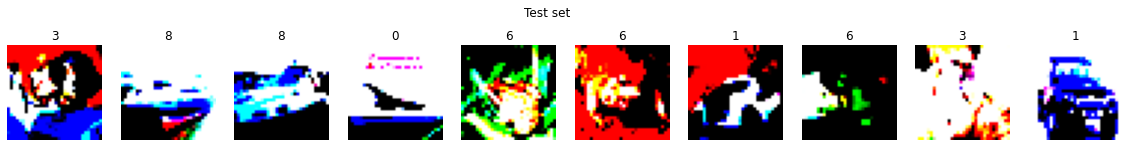

In [7]:
batch = next(iter(generator_train))

figure(0, (20,4))
suptitle('Training set', y=0.8)
for i in range(10):
  subplot(1,10,i+1); imshow( np.clip(batch[0][i],0,1) ); axis('off'); title(str(batch[1][i]));

batch = next(iter(generator_test))
figure(1, (20,4))
suptitle('Test set', y=0.8)
for i in range(10):
  subplot(1,10,i+1); imshow( np.clip(batch[0][i],0,1) ); axis('off'); title(str(batch[1][i]));

***
## **Model Definition and Training Parameters**
- **ResNet18 low resolution version**
- **200 epochs with SGD with momentum and cosine learning rate schedule**

In [10]:
N_EPOCHS        = 200
STEPS_PER_EPOCH = len(x_train)/BATCH_SIZE

cosine_schedule = optax.cosine_decay_schedule(init_value=1.0, decay_steps=STEPS_PER_EPOCH*N_EPOCHS)

module = elegy.nets.resnet.ResNet18(lowres=True, dtype=jnp.float32)
model  = elegy.Model(module, 
                    loss      = elegy.losses.Crossentropy(), 
                    metrics   = elegy.metrics.SparseCategoricalAccuracy(),
                    optimizer = optax.chain(
                                            optax.additive_weight_decay(5e-4),
                                            optax.sgd(0.1, momentum=0.9),
                                            optax.scale_by_schedule(cosine_schedule),
                                           )
                   )


***
## **Training**

In [11]:
model.fit(generator_train,                 steps_per_epoch=STEPS_PER_EPOCH,
          validation_data=generator_test,  validation_steps=len(x_test)/BATCH_SIZE,
          epochs=N_EPOCHS,
          verbose=2)

Epoch 1/200
782/781 - 117s - loss: 2.0351 - sparse_categorical_accuracy: 0.3020 - sparse_categorical_crossentropy_loss: 2.0351 - val_loss: 1.6235 - val_sparse_categorical_accuracy: 0.4171 - val_sparse_categorical_crossentropy_loss: 1.6235
Epoch 2/200
782/781 - 72s - loss: 1.4360 - sparse_categorical_accuracy: 0.4768 - sparse_categorical_crossentropy_loss: 1.4360 - val_loss: 1.3945 - val_sparse_categorical_accuracy: 0.4961 - val_sparse_categorical_crossentropy_loss: 1.3945
Epoch 3/200
782/781 - 72s - loss: 1.1102 - sparse_categorical_accuracy: 0.6045 - sparse_categorical_crossentropy_loss: 1.1102 - val_loss: 1.1149 - val_sparse_categorical_accuracy: 0.6137 - val_sparse_categorical_crossentropy_loss: 1.1149
Epoch 4/200
782/781 - 72s - loss: 0.9482 - sparse_categorical_accuracy: 0.6667 - sparse_categorical_crossentropy_loss: 0.9482 - val_loss: 1.0721 - val_sparse_categorical_accuracy: 0.6303 - val_sparse_categorical_crossentropy_loss: 1.0721
Epoch 5/200
782/781 - 72s - loss: 0.8215 - spar

***

In [12]:
H = model.history.history

Best validation accuracy: 0.95370007


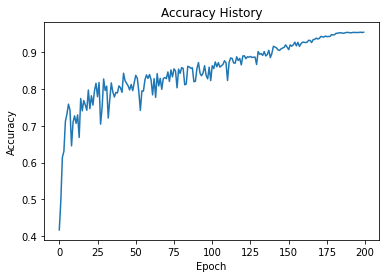

In [13]:
plot(H['val_sparse_categorical_accuracy']);xlabel('Epoch'); ylabel('Accuracy'); title('Accuracy History');
print('Best validation accuracy:', max(H['val_sparse_categorical_accuracy']))